# Tracking objects by color

How it works:
The system tracks object based on their colors.
Steps:
- we treat each frame from video as separete image;
- convert an image into HSV;
- based on color bounds find a mask;
- delete small artifacts;

<img src="res/demo/mask_00.png" width="400" height="200">
<img src="res/demo/mask_01.png" width="400" height="200">

- for each mask, finds contours and draw circle around an object;

<img src="res/demo/Extracted.png" width="400" height="200">


- while processing we save centers of objects into deques;
- later we draw the contrails of objects;
- contrails are thicker near object and thiner away from object.

<img src="res/demo/kang_0500.jpg" width="400" height="200">

## Utilities

In [5]:
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
import time

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

# Show result in seperate window
def show_result(img):
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Saving video utilities
import glob
DEBUG_COUNT = 20

def process_video(path, func, dst_folder, debug = False):
    cap = cv2.VideoCapture(path)
    i = 0
    while(cap.isOpened()):
        # vid_capture.read() methods returns a tuple, first element is a bool 
        # and the second is frame
        ret, frame = cap.read()
        if ret == True:
            f = frame.copy()
            res = func(f)
            
            # Save frame into image file
            s = ""
            if(i < 10):
                s = "000"
            elif(i < 100):
                s = "00"
            elif(i < 1000):
                s = "0"
            cv2.imwrite('res\\' + dst_folder + '\\kang_'+ s +str(i)+'.jpg',res)
            i = i + 1

            # displaying the video
            #cv2.imshow("Processed Video",res)
            if debug and i > DEBUG_COUNT:
                break
                
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()
    
def save_img2video(dst_folder, name = 'output.mp4'):
    # Save images into a video file
    img_array = []
    for filename in glob.glob('res\\' + dst_folder + '\\kang*.jpg'):
        #print(filename)
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(name, cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
def save_clips(path, dst_folder, idxs):
    cap = cv2.VideoCapture(path)
    i = 0
    it = iter(idxs)
    val = next(it)
    while(cap.isOpened()):
        # vid_capture.read() methods returns a tuple, first element is a bool 
        # and the second is frame
        ret, frame = cap.read()
        i = i + 1
        if ret == True:
            if i == val:
                cv2.imwrite(dst_folder + '\\clip_' +str(i)+'.png',frame)
                
                try:
                    val = next(it)
                except:
                    break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

In [7]:
def param_selection(image, args_dict, func):
    def nothing(x):
        pass
    # Create a window
    cv2.namedWindow('image')
    args = args_dict.keys()
    # Initialize values
    vals = np.zeros(len(args), dtype='int')
    pVals = np.zeros(len(args), dtype='int')
    for arg in args:
        val = args_dict[arg]
        cv2.createTrackbar(arg, 'image', val[0], val[1], nothing)
    for arg in args:
        val = args_dict[arg]
        cv2.setTrackbarPos(arg, 'image', val[2])

    # Get current positions of all trackbars
        for i, arg in enumerate(args):
            vals[i] = cv2.getTrackbarPos(arg, 'image')
    result = func(image, vals) # Apply changes

    while(1):
        # Get current positions of all trackbars
        for i, arg in enumerate(args):
            vals[i] = cv2.getTrackbarPos(arg, 'image')

        if np.any(np.not_equal(vals, pVals)):
            result = func(image, vals) # Apply changes
            s = ""
            for i, arg in enumerate(args):
                s = s + arg + " = " + str(vals[i]) + " "
            print(s)
            for i in range(len(args)):
                pVals[i] = vals[i]

        # Display result image
        cv2.imshow('image', result)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cv2.destroyWindow("image")
    cv2.destroyAllWindows()
    
# Collect images during changes to show them with or without histogram
def plot_steps(imgs, names, cols = 3, with_hist = False):
    n = len(imgs)
    rows = int(np.ceil(n / cols))
    k = 2 if with_hist else 1
    fig, axs = plt.subplots(k * rows, cols, figsize=(24, 6 * k * rows))
    for ax in axs.ravel(): # remove axis from all canvas
        ax.axis("off")
    for i, img in enumerate(imgs):
        if with_hist:
            ax = axs[k * (i // cols) + 1, i % cols]
            #print(image.ndim)
            #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.hist(img.ravel())
        ax = axs[k * (i // cols), i % cols]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(names[i])
        
def plot_result(original, result):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    ax = axs[0]
    ax.imshow(original)
    ax.set_title('Original')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axs[1]
    ax.imshow(result, cmap='gray', label='Result')
    ax.set_title('Result')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
def plot_histogram(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(hist)
    plt.xlim([0,256])
    
# Delete small white pixels
def delete_small_artifacts(img):
    kernel = np.ones((4,4),np.uint8)
    img = cv2.erode(img,kernel,iterations = 2)
    img = cv2.dilate(img,kernel,iterations = 2)
    return img

# Show result in seperate window
def show_result(img):
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Choose only contours that big enough
def filter_contours(contours, upper_area_thresh = 100):
    # Find contours with area more than area_thresh
    contours = np.array(contours, dtype='object')
    f = np.vectorize(cv2.contourArea)
    areas = f(contours)
    areas = np.where(areas > upper_area_thresh)
    contours = contours[areas]
    return contours
    
def fill_contours(img, upper_area_thresh = 100, color = (0, 0, 0), external = False, clear_background = False, show_border = False):
    mode = cv2.RETR_EXTERNAL if external else cv2.RETR_TREE
    contours, hierarchy  = cv2.findContours(img, mode, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
    contours = filter_contours(contours, upper_area_thresh)
    if clear_background:
        img = np.zeros([img.shape[0], img.shape[1]],dtype=np.uint8)
        img =255 - img
    if show_border:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img, contours, -1, (0, 255, 255), 5)
    for cnt in contours:
        cv2.fillPoly(img, pts=[cnt], color=color)
    print('Count of objects', len(contours))
    return img
    
def draw_border(img, thickness = 5, mode = 0):
    # mode = 0 - top line, 1 - right, 2 - bottom, 3 - left
    color = (255, 255, 255)
    if mode == 0:
        cv2.line(img,(0,0),(img.shape[1],0),color,thickness=thickness)
    if mode == 1:
        cv2.line(img,(img.shape[1],0),(img.shape[1],img.shape[0]),color,thickness=thickness)
    if mode == 2:
        cv2.line(img,(0,img.shape[0]),(img.shape[1],img.shape[0]),color,thickness=thickness)
    if mode == 3:
        cv2.line(img,(0,0),(0,img.shape[0]),color,thickness)
    return img

## Tracking

In [8]:
args = {"video": "tracking_by_color.mp4", "buffer": 64}
VIDEO_PATH = args["video"]

### Parameter selection

In [9]:
save_clips(VIDEO_PATH, 'tmp', [5, 267, 400, 500, 700])  

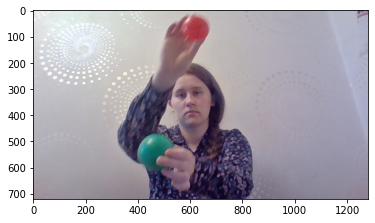

In [47]:
IMG_PATH = "tmp\clip_500.png"
image = cv2.imread(IMG_PATH)
img = image.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [49]:
d = {'hMin': (0, 179, 0), 'sMin': (0, 255, 0), 'vMin': (0, 255, 0), 'hMax': (0, 179, 179), 'sMax': (0, 255, 255), 'vMax': (0, 255, 255)}
def inRange(image, vals):
    image = imutils.resize(image, width=1200)
    lower = np.array([vals[0], vals[1], vals[2]])
    upper = np.array([vals[3], vals[4], vals[5]])
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    res = cv2.bitwise_and(image, image, mask=mask)
    return res
param_selection(img, d, inRange)

hMin = 0 sMin = 0 vMin = 0 hMax = 179 sMax = 255 vMax = 255 


### Tracking objects

In [50]:
greenLower = (32, 27, 46)
greenUpper = (99, 255, 239)
redLower = (113, 130, 106)
redUpper = (179, 255, 255)
bounds = [(greenLower, greenUpper), (redLower, redUpper)]

In [101]:
def mask_by_color(hsv, low, up):
    mask = cv2.inRange(hsv, low, up)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    return mask
def extract_by_color(img):
    # resize the frame, blur it, and convert it to the HSV
    # color space
    blurred = cv2.GaussianBlur(img, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    # construct a mask for the color "green", then perform
    # a series of dilations and erosions to remove any small
    # blobs left in the mask
    mask1 = mask_by_color(hsv, greenLower, greenUpper)
    mask2 = mask_by_color(hsv, redLower, redUpper)
    mask = cv2.bitwise_or(mask1, mask2)
    return mask

def extract_by_colors(img, bounds = bounds):
    # resize the frame, blur it, and convert it to the HSV
    # color space
    blurred = cv2.GaussianBlur(img, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    # construct a mask for the color "green", then perform
    # a series of dilations and erosions to remove any small
    # blobs left in the mask
    masks = []
    for low, up in bounds:
        mask = mask_by_color(hsv, low, up)
        masks.append(mask)
    return masks

idx = 2
ptss = {0: dict(), 1: dict()}
def find_contour(image, mask, i):
    global idx
    # find contours in the mask and initialize the current
    # (x, y) center of the ball
    cnts, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cnts = imutils.grab_contours(cnts)
    center = None
    # only proceed if at least one contour was found
    if len(cnts) > 0:
        key_used = set()
        #c = max(cnts, key=cv2.contourArea)
        pts = ptss[i]
        for c in cnts:
            area = cv2.contourArea(c)
            if area < 400:
                continue
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            # only proceed if the radius meets a minimum size
            if radius > 25:
            # draw the circle and centroid on the frame,
            # then update the list of tracked points
                cv2.circle(image, (int(x), int(y)), int(radius), (0, 255, 255), 2)
                cv2.circle(image, center, 5, (0, 0, 255), -1)
            if not pts:
                pts[1] = deque(maxlen=args["buffer"])
                pts[1].appendleft(center)
                key_used.add(1)
            else:
                for key in pts:
                    pt = pts[key]
                    prev = pt.popleft()
                    pt.appendleft(prev)
                    if prev == None:
                        continue
                    dist = (prev[0] - center[0]) ** 2 + (prev[1] - center[1]) ** 2
                    if dist < 10000:
                        pt.appendleft(center)
                        key_used.add(key)
                if len(key_used) == 0:
                    # New object
                    pts[idx] = deque(maxlen=args["buffer"])
                    pts[idx].appendleft(center)
                    key_used.add(idx)
                    idx = idx + 1
        for key in pts:
            if not(key in key_used):
                pts[key].appendleft(None)
                    
                
    return image
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
def draw_contrail(image, pts_dict):
    for i in pts_dict:
        pts_s = pts_dict[i]
        color = colors[i % len(colors)]
        for key in pts_s:
            pts = pts_s[key]
            for i in range(1, len(pts)):
            # if either of the tracked points are None, ignore them
                if pts[i - 1] is None or pts[i] is None:
                    continue
                # otherwise, compute the thickness of the line and
                # draw the connecting lines
                thickness = int(np.sqrt(args["buffer"] / float(i + 1)) * 2.5)
                cv2.line(image, pts[i - 1], pts[i], color, thickness)
    return image
    

def process(image, debug = True):
    masks = extract_by_colors(image)
    for i, mask in enumerate(masks):
        image = find_contour(image, mask, i)
    image = draw_contrail(image, ptss) 
    if debug:
        for i, mask in enumerate(masks):
            cv2.imwrite("debug/mask_0" + str(i) + ".png", mask)
    
    return image
    

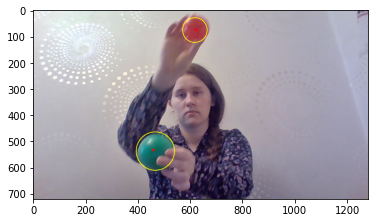

In [102]:
img = image.copy()
res = process(img, True)
cv2.imwrite("Extracted.png", res)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(res)

In [92]:
ptss

{0: {1: deque([(460, 533)])}, 1: {1: deque([(623, 76)])}}

In [93]:
def clear_folder(folder):
    import os, shutil
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [98]:
clear_folder('res/tmp_extract')
idx = 2
ptss = {0: dict(), 1: dict()}

In [100]:
process_video(VIDEO_PATH, process, 'tmp_extract', debug = False)

In [103]:
save_img2video('tmp_extract', 'tracked.mp4')

# References
- Ball Tracking with OpenCV by Adrian Rosebrock on September 14, 2015, https://pyimagesearch.com/2015/09/14/ball-tracking-with-opencv/